# Prepare matplotlib

In [1]:
import json
from collections import defaultdict
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats as sps

rc_fonts = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [r"\usepackage{libertine}", r"\usepackage[libertine]{newtxmath}", r"\usepackage{inconsolata}"]
    ),
}
mpl.rcParams.update(rc_fonts)
sns.set_theme(rc={"text.usetex": True}, context="paper")

In [2]:
TICK_LABEL_SIZE = 14
AXIS_LABEL_SIZE = 16

# Load data

In [3]:
# Functions for loading BLiMP data


def load_blimp_data(path: Path) -> dict:
    with path.open() as f:
        data = json.load(f)
    if "blimp" in data:
        data = data["blimp"]
    return data


def get_uids(data: dict):
    return np.array(list(data["by_uid"].values()))

# Load data for phenomenon plots

In [4]:
blimp_uid_to_phenomenon = {
    # Anaphor Agreement
    "anaphor_gender_agreement": "Anaphor Agreement",
    "anaphor_number_agreement": "Anaphor Agreement",
    "animate_subject_passive": "Anaphor Agreement",
    "animate_subject_trans": "Anaphor Agreement",
    # Argument Structure
    "causative": "Argument Structure",
    "drop_argument": "Argument Structure",
    "inchoative": "Argument Structure",
    "intransitive": "Argument Structure",
    "passive_1": "Argument Structure",
    "passive_2": "Argument Structure",
    "transitive": "Argument Structure",
    # Binding
    "principle_A_c_command": "Binding",
    "principle_A_case_1": "Binding",
    "principle_A_case_2": "Binding",
    "principle_A_domain_1": "Binding",
    "principle_A_domain_2": "Binding",
    "principle_A_domain_3": "Binding",
    "principle_A_reconstruction": "Binding",
    # Control/Raising
    "existential_there_object_raising": "Control/Raising",
    "existential_there_subject_raising": "Control/Raising",
    "tough_vs_raising_1": "Control/Raising",
    "tough_vs_raising_2": "Control/Raising",
    "expletive_it_object_raising": "Control/Raising",
    # Determiner-Noun Agreement
    "determiner_noun_agreement_1": "Determiner-Noun Agreement",
    "determiner_noun_agreement_2": "Determiner-Noun Agreement",
    "determiner_noun_agreement_irregular_1": "Determiner-Noun Agreement",
    "determiner_noun_agreement_irregular_2": "Determiner-Noun Agreement",
    "determiner_noun_agreement_with_adj_1": "Determiner-Noun Agreement",
    "determiner_noun_agreement_with_adjective_1": "Determiner-Noun Agreement",  # appears like this too
    "determiner_noun_agreement_with_adj_2": "Determiner-Noun Agreement",
    "determiner_noun_agreement_with_adj_irregular_1": "Determiner-Noun Agreement",
    "determiner_noun_agreement_with_adj_irregular_2": "Determiner-Noun Agreement",
    # Ellipsis
    "ellipsis_n_bar_1": "Ellipsis",
    "ellipsis_n_bar_2": "Ellipsis",
    # Filler-Gap
    "wh_questions_object_gap": "Filler-Gap",
    "wh_questions_subject_gap": "Filler-Gap",
    "wh_questions_subject_gap_long_distance": "Filler-Gap",
    "wh_vs_that_no_gap": "Filler-Gap",
    "wh_vs_that_no_gap_long_distance": "Filler-Gap",
    "wh_vs_that_with_gap": "Filler-Gap",
    "wh_vs_that_with_gap_long_distance": "Filler-Gap",
    # Irregular Forms
    "irregular_past_participle_adjectives": "Irregular Forms",
    "irregular_past_participle_verbs": "Irregular Forms",
    # Island Effects
    "adjunct_island": "Island Effects",
    "complex_NP_island": "Island Effects",
    "coordinate_structure_constraint_complex_left_branch": "Island Effects",
    "coordinate_structure_constraint_object_extraction": "Island Effects",
    "left_branch_island_echo_question": "Island Effects",
    "left_branch_island_simple_question": "Island Effects",
    "sentential_subject_island": "Island Effects",
    "wh_island": "Island Effects",
    # NPI Licensing
    "matrix_question_npi_licensor_present": "NPI Licensing",
    "npi_present_1": "NPI Licensing",
    "npi_present_2": "NPI Licensing",
    "only_npi_licensor_present": "NPI Licensing",
    "only_npi_scope": "NPI Licensing",
    "sentential_negation_npi_licensor_present": "NPI Licensing",
    "sentential_negation_npi_scope": "NPI Licensing",
    # Quantifiers
    "existential_there_quantifiers_1": "Quantifiers",
    "existential_there_quantifiers_2": "Quantifiers",
    "superlative_quantifiers_1": "Quantifiers",
    "superlative_quantifiers_2": "Quantifiers",
    # Subject-Verb Agreement
    "distractor_agreement_relational_noun": "Subject-Verb Agreement",
    "distractor_agreement_relative_clause": "Subject-Verb Agreement",
    "irregular_plural_subject_verb_agreement_1": "Subject-Verb Agreement",
    "irregular_plural_subject_verb_agreement_2": "Subject-Verb Agreement",
    "regular_plural_subject_verb_agreement_1": "Subject-Verb Agreement",
    "regular_plural_subject_verb_agreement_2": "Subject-Verb Agreement",
}


phenomena = sorted(list(set(blimp_uid_to_phenomenon.values())))


def group_by_phenomenon(data: dict):
    res = defaultdict(list)
    for uid, val in data["by_uid"].items():
        res[blimp_uid_to_phenomenon[uid]].append(val)
    return res

In [5]:
def shorten_label(label: str):
    label = label.replace("Agreement", "Agr")
    label = label.replace("Anaphor", "Ana.")
    label = label.replace("Argument", "Arg.")
    label = label.replace("Structure", "Str")
    label = label.replace("Control", "Ctrl.")
    label = label.replace("Raising", "Rais.")
    label = label.replace("Determiner-Noun", "D-N")
    label = label.replace("Forms", "")
    label = label.replace("Effects", "")
    label = label.replace("Licensing", "")
    label = label.replace("Subject-Verb", "S-V")
    return label

In [6]:
# Load all BLiMP data -- by phenomenon

STEP = 20_000

models = [rf"\texttt{{pico-{t}}}" for t in ("decoder", "relora")]


def _get_data():
    for scale in ("tiny", "small"):
        baseline_data = load_blimp_data(Path(f"blimp_results_{scale}/step_{STEP}.json"))
        relora_data = load_blimp_data(Path(f"relora-{scale}-eval/step_{STEP}.json"))

        for mod, data in zip(models, (baseline_data, relora_data)):
            for uid, val in data["by_uid"].items():
                yield (scale, mod, shorten_label(blimp_uid_to_phenomenon[uid]), uid, val)


data = pd.DataFrame(_get_data(), columns=["Scale", "Model", "Phenomenon", "UID", "Score"])

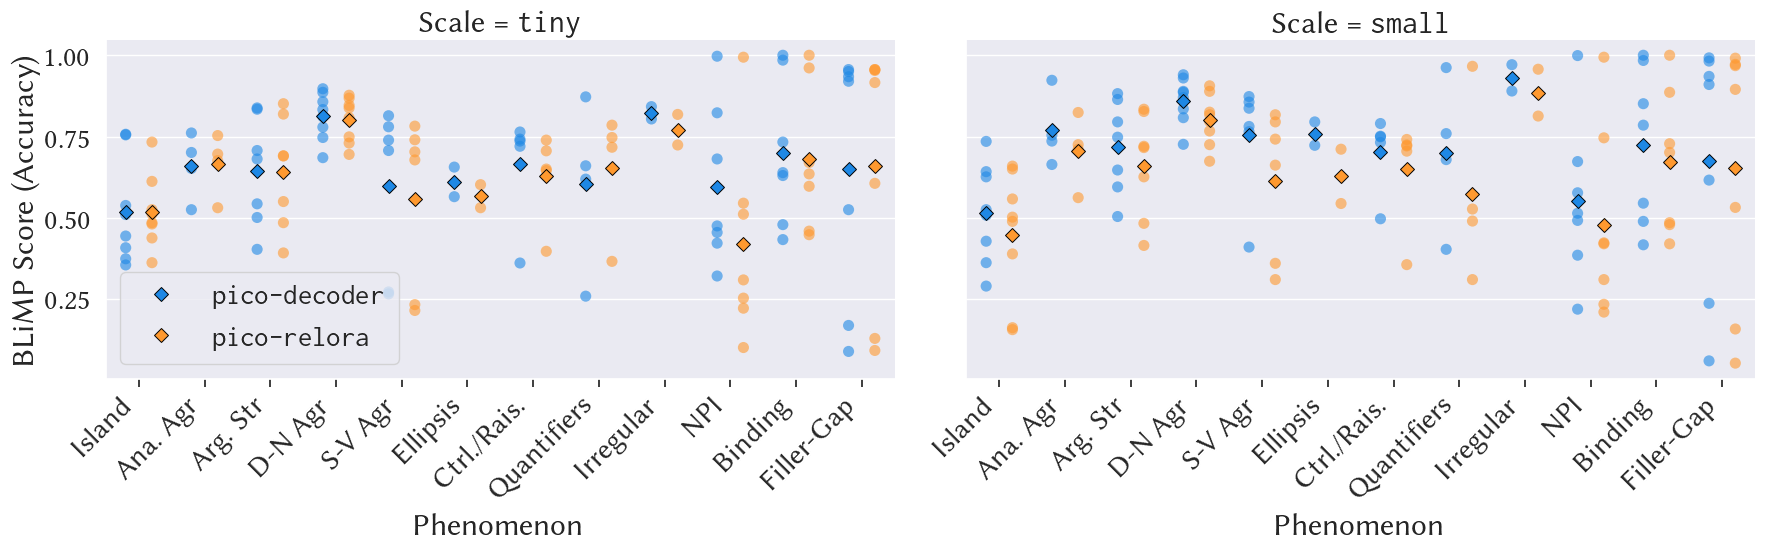

In [16]:
# Create a strip plot using FacetGrid
colors = ["#1E88E5", "#FF992F"]
palette = dict(zip(models, colors))

dodge = 0.4
size = 8
font_scale = 1.9

sns.set_theme(
    font_scale=font_scale, rc={"xtick.bottom": True, "axes.grid": "True", "axes.grid.which": "both"}
)

g = sns.FacetGrid(data=data, col="Scale", height=6, aspect=1.5, sharey=True)


# Add the stripplot with hue and dodge
g.map_dataframe(
    sns.stripplot,
    x="Phenomenon",
    y="Score",
    hue="Model",
    size=size,
    alpha=0.6,
    jitter=False,
    dodge=dodge,
    palette=palette,
    legend=False,
    zorder=1,
)

# Add the pointplot with hue and dodge (for means)
g.map_dataframe(
    sns.pointplot,
    x="Phenomenon",
    y="Score",
    hue="Model",
    dodge=dodge,
    markers="D",
    markersize=size - 1,
    markeredgecolor="black",
    markeredgewidth=0.7,
    err_kws={"linewidth": 0},
    linestyles="none",
    palette=palette,
    zorder=6,
)

g.set_titles(col_template=r"Scale = \texttt{{{col_name}}}")

# Rotate x-ticks and label axes
g.set_xticklabels(rotation=45, ha="right")
g.set_axis_labels("Phenomenon", "BLiMP Score (Accuracy)")

# Only add legend once
# g.add_legend(title="Model", facecolor="white")

for ax_idx, ax in enumerate(g.axes.flat):
    if ax_idx == 0:
        ax.legend(bbox_to_anchor=(0, 0), loc="lower left")

# Adjust layout to prevent label cutting
plt.tight_layout()

# Show the plot
plt.savefig("../graphs/blimp_phenom_strip.pdf", bbox_inches="tight")
plt.show()

# Investigate into tiny quantifiers

In [8]:
blimp_phen_to_uid = defaultdict(set)
for k, v in blimp_uid_to_phenomenon.items():
    blimp_phen_to_uid[v].add(k)

In [9]:
data_20k = {
    "decoder": {
        "tiny": load_blimp_data(Path("blimp_results_tiny/step_20000.json"))["by_uid"],
        "small": load_blimp_data(Path("blimp_results_small/step_20000.json"))["by_uid"],
    },
    "relora": {
        "tiny": load_blimp_data(Path("relora-tiny-eval/step_20000.json"))["by_uid"],
        "small": load_blimp_data(Path("relora-small-eval/step_20000.json"))["by_uid"],
    },
}

In [10]:
quantifier_uids = blimp_phen_to_uid["Quantifiers"]
for scale in ("tiny", "small"):
    print(scale)
    for q in sorted(quantifier_uids):
        d = data_20k["decoder"][scale][q]
        r = data_20k["relora"][scale][q]

        got = r * 1000
        p_val = sps.binom.cdf(round(got), 1000, d)
        if got > d * 1000:
            p_val = 1 - p_val

        p_val *= 2

        print(f"{q}: dec = {d}, rel = {r}, pval = {p_val}")

tiny
existential_there_quantifiers_1: dec = 0.871999979019165, rel = 0.7850000262260437, pval = 3.3470784282999356e-14
existential_there_quantifiers_2: dec = 0.2590000033378601, rel = 0.3659999966621399, pval = 7.394085344003543e-14
superlative_quantifiers_1: dec = 0.6190000176429749, rel = 0.7170000076293945, pval = 5.886380272102087e-11
superlative_quantifiers_2: dec = 0.6600000262260437, rel = 0.746999979019165, pval = 2.170335244855437e-09
small
existential_there_quantifiers_1: dec = 0.9620000123977661, rel = 0.9660000205039978, pval = 0.4635623395407269
existential_there_quantifiers_2: dec = 0.40299999713897705, rel = 0.3100000023841858, pval = 1.388412276352072e-09
superlative_quantifiers_1: dec = 0.6790000200271606, rel = 0.49000000953674316, pval = 6.933089385517057e-35
superlative_quantifiers_2: dec = 0.7590000033378601, rel = 0.5270000100135803, pval = 7.414093174385998e-57


In [11]:
quantifier_uids = blimp_phen_to_uid["NPI Licensing"]
for scale in ("tiny", "small"):
    print(scale)
    for q in sorted(quantifier_uids):
        d = data_20k["decoder"][scale][q]
        r = data_20k["relora"][scale][q]

        got = r * 1000
        p_val = sps.binom.cdf(round(got), 1000, d)
        if got > d * 1000:
            p_val = 1 - p_val

        p_val *= 2

        print(f"{q}: dec = {d}, rel = {r}, pval = {p_val}")

tiny
matrix_question_npi_licensor_present: dec = 0.32100000977516174, rel = 0.22200000286102295, pval = 5.55802055537583e-12
npi_present_1: dec = 0.45500001311302185, rel = 0.2529999911785126, pval = 1.5602159617060545e-39
npi_present_2: dec = 0.4749999940395355, rel = 0.3089999854564667, pval = 1.9167206693490717e-26
only_npi_licensor_present: dec = 0.6809999942779541, rel = 0.10100000351667404, pval = 1.4e-322
only_npi_scope: dec = 0.8230000138282776, rel = 0.5450000166893005, pval = 6.651358251282819e-91
sentential_negation_npi_licensor_present: dec = 0.996999979019165, rel = 0.9940000176429749, pval = 0.1672340847602596
sentential_negation_npi_scope: dec = 0.421999990940094, rel = 0.5109999775886536, pval = 1.2454681730389439e-08
small
matrix_question_npi_licensor_present: dec = 0.21899999678134918, rel = 0.20999999344348907, pval = 0.5184310978677441
npi_present_1: dec = 0.6729999780654907, rel = 0.3100000023841858, pval = 2.741348250424831e-121
npi_present_2: dec = 0.577000021934